Standart floquette stability analysis 

In [66]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 14 21:53:22 2024

@author: holli
"""

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Systemparameter
kappa = 1
gamma = 1
Gamma = 1
delta_1 = 1
delta_2 = 1
Omega = 6
V = -4
eta = 1
g_0 = 1

# Anfangswerte basierend auf den gegebenen Bedingungen
a0 = 0 + 0j
a_dagger_0 = 0 + 0j
psi00 = 1
psi22 = 0 + 0j

#V_cond = -delta_2 / 2 * ((Omega * kappa)**2 / (16 * (eta * gamma)**2) + 1)
psi20=0 + 0j
psi02=0 + 0j
psi11 = 0 + 0j
psi10 = 0.0 + 0j
psi01 = 0.0 + 0j
psi21 = 0.0 + 0j
psi12 = 0.0 + 0j

startcond = [a0, a_dagger_0, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02]

# Differentialgleichungssystem
def dydt(t, y):
    a, a_dagger, ket00, ket01, ket10, ket11, ket22, ket21, ket12, ket20, ket02 = y
    
    da_dt = -kappa/2 * a - 1j * (gamma * ket01) + eta
    da_dagger_dt = np.conj(da_dt)
    dket00_dt = +Gamma * ket11 + 1j * gamma * (ket10 * a - ket01 * a_dagger)
    dket01_dt = -Gamma/2 * ket01 + 1j * (-delta_1 * ket01 + gamma * (ket11 * a - ket00 * a) - Omega/2 * ket02)
    dket10_dt = np.conj(dket01_dt)
    dket11_dt = -Gamma * ket11 + 1j * gamma * (ket01 * a_dagger - ket10 * a) + 1j * Omega/2 * (ket21 - ket12)
    dket22_dt = 1j * Omega / 2 * (ket12 - ket21)
    dket21_dt = -Gamma/2 * ket21 + 1j * (delta_2 * ket21 - delta_1 * ket21 - gamma * ket20 * a + Omega/2 * (ket11 - ket22) + 2 * V * ket21 * ket22)
    dket12_dt = np.conj(dket21_dt)
    dket02_dt = 1j * (-delta_2 * ket02 - Omega/2 * ket01 - 2 * V * ket02 * ket22 + gamma * ket12 * a)
    dket20_dt = np.conj(dket02_dt)
    
    return [da_dt, da_dagger_dt, dket00_dt, dket01_dt, dket10_dt, dket11_dt, dket22_dt, dket21_dt, dket12_dt, dket20_dt, dket02_dt]

# Numerische Integration mit DOP853
t_span = (0, 5000)  # Längere Simulationszeit
t_eval = np.linspace(0, 5000, 500000)  # Höhere Auflösung
sol = solve_ivp(dydt, t_span, startcond, method='DOP853', t_eval=t_eval, dense_output=True, atol=1e-12, rtol=1e-12)

# Definition von t und y
t = sol.t
y = sol.y

# Maxima finden (nach den ersten 500 Sekunden)
def find_maxima(y, t, ignore_time=500):
    maxima_indices = []
    ignore_index = np.searchsorted(t, ignore_time)
    for i in range(ignore_index, len(y) - 1):
        if y[i - 1] < y[i] and y[i + 1] < y[i]:
            maxima_indices.append(i)
    return maxima_indices

# Maxima für jede Lösung finden
maxima_indices_list = []
periods = []

for i in range(len(y)):
    maxima_indices = find_maxima(np.real(y[i]), t)
    maxima_indices_list.append(maxima_indices)
    if len(maxima_indices) > 1:
        period = np.mean(np.diff(t[maxima_indices]))
        periods.append(period)
    else:
        periods.append(np.nan)

# # Abstände der ersten und letzten 5 Maxima vergleichen
# for i in range(len(y)):
#     if len(maxima_indices_list[i]) >= 10:
#         first_five_maxima = y[i, maxima_indices_list[i][:5]]
#         last_five_maxima = y[i, maxima_indices_list[i][-5:]]
#         print(f"Lösung {i}:")
#         print(f"  Erste 5 Maxima: {first_five_maxima}")
#         print(f"  Letzte 5 Maxima: {last_five_maxima}")

#         # Abstände der Maxima berechnen
#         first_distances = np.diff(t[maxima_indices_list[i][:5]])
#         last_distances = np.diff(t[maxima_indices_list[i][-5:]])
#         print(f"  Abstände der ersten 5 Maxima: {first_distances}")
#         print(f"  Abstände der letzten 5 Maxima: {last_distances}")

# Definition der Jacobi-Matrix des linearisierten Systems
def jacobian_linearized(a, a_dagger, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02, g_0=1, Delta_1=1, Delta_2=1):
    M = np.array([
        [-kappa / 2, 0, 0, 0, 0, 0, -1j * gamma * g_0, 0, 0, 0, 0],
        [0, -kappa / 2, 0, 0, 0, 1j * gamma * g_0, 0, 0, 0, 0, 0],
        [1j * gamma * g_0 * psi10, -1j * gamma * g_0 * psi01, 0, Gamma, 0, 1j * g_0 * gamma * a, -1j * g_0 * gamma * a_dagger, 0, 0, 0, 0],
        [-1j * gamma * g_0 * psi10, 1j * gamma * g_0 * psi01, 0, -Gamma, 0, -1j * gamma * g_0 * a, 1j * gamma * g_0 * a_dagger, 1j * Omega / 2, -1j * Omega / 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, -1j * Omega / 2, 1j * Omega / 2, 0, 0],
        [0, -1j * gamma * g_0 * (psi11 - psi00), 1j * gamma * g_0 * a_dagger, -1j * gamma * g_0 * a_dagger, 0, -Gamma / 2 + 1j * Delta_1, 0, 0, 0, 1j * Omega / 2, 0],
        [1j * gamma * g_0 * (psi11 - psi00), 0, -1j * gamma * g_0 * a, 1j * gamma * g_0 * a, 0, 0, -Gamma / 2 - 1j * Delta_1, 0, 0, 0, -1j * Omega / 2],
        [-1j * gamma * g_0 * psi20, 0, 0, 1j * Omega / 2, 1j * (2 * V * psi21 - Omega / 2), 0, 0, -Gamma / 2 + 1j * (Delta_2 - Delta_1 + 2 * V * psi22), 0, -1j * gamma * g_0 * a, 0],
        [0, 1j * gamma * g_0 * psi02, 0, -1j * Omega / 2, -2j * V * psi12 + 1j * Omega / 2, 0, 0, 0, -Gamma / 2 + 1j * (Delta_1 - Delta_2 - 2 * V * psi22), 0, 1j * gamma * g_0 * a_dagger],
        [0, -1j * gamma * g_0 * psi21, 0, 0, 2j * V * psi20, 1j * Omega / 2, 0, -1j * gamma * g_0 * a_dagger, 0, 1j * (Delta_2 + 2 * V * psi22), 0],
        [1j * g_0 * gamma * psi12, 0, 0, 0, -2j * V * psi02, 0, -1j * Omega / 2, 0, 1j * gamma * g_0 * a, 0, -1j * (Delta_2 + 2 * V * psi22)]
    ])
    return M

# Floquet-Analyse über mehrere Perioden mit linearisiertem System
def floquet_analysis(sol, periods, num_periods=5):
    t_fin = sol.t[-1]
    t_start = t_fin - periods[-1] * num_periods
    y0 = sol.sol(t_start)
    n = len(y0)
    J0 = np.eye(n, dtype=complex)  # Initial matrix is identity

    def variational_eq(t, Y):
        Y = Y.reshape((n, n + 1))
        dy = dydt(t, Y[:, 0])
        a, a_dagger, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02 = Y[:, 0]
        A = jacobian_linearized(a, a_dagger, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02)
        
        dYdt = np.zeros_like(Y)
        dYdt[:, 0] = dy
        dYdt[:, 1:] = A @ Y[:, 1:]
        return dYdt.flatten()

    t_eval = np.linspace(t_start, t_fin, num_periods * 100)
    Y0 = np.hstack([y0[:, None], J0]).flatten()
    sol_var = solve_ivp(variational_eq, [t_start, t_fin], Y0, t_eval=t_eval, method='DOP853', dense_output=True)

    YT = sol_var.sol(t_fin).reshape((n, n + 1))
    monodromy_matrix = YT[:, 1:]
    floquet_multipliers = np.linalg.eigvals(monodromy_matrix)

    # Skalieren der Floquet-Multiplikatoren für eine Periode
    floquet_multipliers_single_period = np.power(floquet_multipliers, 1/num_periods)

    return floquet_multipliers_single_period

# Berechnung der Floquet-Multiplikatoren für jede Periode
floquet_results = []
for i, period in enumerate(periods):
    if not np.isnan(period):
        print(f"Lösung {i}: Periode = {period}")
        floquet_multipliers = floquet_analysis(sol, periods, num_periods=5)
        floquet_results.append((i, floquet_multipliers))
        print(f"Floquet-Multiplikatoren für Lösung {i}:")
        for j in floquet_multipliers:
            print(abs(j))

# Floquet-Ergebnisse anzeigen
import math 
for result in floquet_results:
    i, multipliers = result
    print(f"Lösung {i}:")
    for multiplier in multipliers:
        if math.isclose(multiplier, 1.0, rel_tol=10**(-8)):
            
            print(f" stable:{abs(multiplier)}")
            
        elif abs(multiplier)<1-10**(-8):
            print(f" decaying:{abs(multiplier)}")
        elif abs(multiplier)>1+10**(-8):
            print(f" increasing:{abs(multiplier)}")
            


Lösung 0: Periode = 1.5941243788936905
Floquet-Multiplikatoren für Lösung 0:
0.9851266751346403
0.8996275426187376
0.8400742805820878
0.7407461924234573
0.6872314900942945
0.6872314900749146
0.6405709213805729
0.6405709213727708
0.6517746315581715
0.591951132996535
1.0
Lösung 1: Periode = 1.5941243788936905
Floquet-Multiplikatoren für Lösung 1:
0.9851266751346403
0.8996275426187376
0.8400742805820878
0.7407461924234573
0.6872314900942945
0.6872314900749146
0.6405709213805729
0.6405709213727708
0.6517746315581715
0.591951132996535
1.0
Lösung 2: Periode = 1.594120835300494
Floquet-Multiplikatoren für Lösung 2:
0.9851266751346403
0.8996275426187376
0.8400742805820878
0.7407461924234573
0.6872314900942945
0.6872314900749146
0.6405709213805729
0.6405709213727708
0.6517746315581715
0.591951132996535
1.0
Lösung 3: Periode = 1.5941243788936905
Floquet-Multiplikatoren für Lösung 3:
0.9851266751346403
0.8996275426187376
0.8400742805820878
0.7407461924234573
0.6872314900942945
0.6872314900749146


/tmp/ipykernel_27021/238945876.py:170: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isclose(multiplier, 1.0, rel_tol=10**(-8)):


Lösung 0: Periode = 1.5941243788936905
Floquet-Multiplikatoren für Lösung 0:
0.9999604250589444
0.6320719329031952
0.6320719329058887
0.5224897855627616
0.5224897855333053
0.4474638245259901
0.46996287137852283
0.43352476695176795
0.3827249318962073
0.4474638245062586
1.0000000000071725
Lösung 1: Periode = 1.5941243788936905
Floquet-Multiplikatoren für Lösung 1:
0.9999604250589444
0.6320719329031952
0.6320719329058887
0.5224897855627616
0.5224897855333053
0.4474638245259901
0.46996287137852283
0.43352476695176795
0.3827249318962073
0.4474638245062586
1.0000000000071725
Lösung 2: Periode = 1.594120835300494
Floquet-Multiplikatoren für Lösung 2:
0.9999604250589444
0.6320719329031952
0.6320719329058887
0.5224897855627616
0.5224897855333053
0.4474638245259901
0.46996287137852283
0.43352476695176795
0.3827249318962073
0.4474638245062586
1.0000000000071725
Lösung 3: Periode = 1.5941243788936905
Floquet-Multiplikatoren für Lösung 3:
0.9999604250589444
0.6320719329031952
0.6320719329058887
0.5

/tmp/ipykernel_27021/558707553.py:152: ComplexWarning: Casting complex values to real discards the imaginary part
  if math.isclose(multiplier, 1.0, rel_tol=10**(-8)):


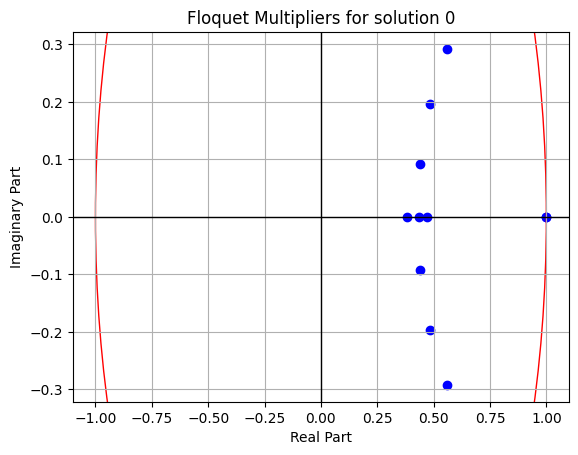

In [68]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from numpy.linalg import cond

# Systemparameter
kappa = 1
gamma = 1
Gamma = 1
delta_1 = 1
delta_2 = 1
Omega = 6
V = -4
eta = 1
g_0 = 1

# Anfangswerte basierend auf den gegebenen Bedingungen
a0 = 0 + 0j
a_dagger_0 = 0 + 0j
psi00 = 1
psi22 = 0 + 0j
psi20 = 0 + 0j
psi02 = 0 + 0j
psi11 = 0 + 0j
psi10 = 0.0 + 0j
psi01 = 0.0 + 0j
psi21 = 0.0 + 0j
psi12 = 0.0 + 0j

startcond = [a0, a_dagger_0, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02]

# Differentialgleichungssystem
def dydt(t, y):
    a, a_dagger, ket00, ket01, ket10, ket11, ket22, ket21, ket12, ket20, ket02 = y
    
    da_dt = -kappa/2 * a - 1j * (gamma * ket01) + eta
    da_dagger_dt = np.conj(da_dt)
    dket00_dt = +Gamma * ket11 + 1j * gamma * (ket10 * a - ket01 * a_dagger)
    dket01_dt = -Gamma/2 * ket01 + 1j * (-delta_1 * ket01 + gamma * (ket11 * a - ket00 * a) - Omega/2 * ket02)
    dket10_dt = np.conj(dket01_dt)
    dket11_dt = -Gamma * ket11 + 1j * gamma * (ket01 * a_dagger - ket10 * a) + 1j * Omega/2 * (ket21 - ket12)
    dket22_dt = 1j * Omega / 2 * (ket12 - ket21)
    dket21_dt = -Gamma/2 * ket21 + 1j * (delta_2 * ket21 - delta_1 * ket21 - gamma * ket20 * a + Omega/2 * (ket11 - ket22) + 2 * V * ket21 * ket22)
    dket12_dt = np.conj(dket21_dt)
    dket02_dt = 1j * (-delta_2 * ket02 - Omega/2 * ket01 - 2 * V * ket02 * ket22 + gamma * ket12 * a)
    dket20_dt = np.conj(dket02_dt)
    
    return [da_dt, da_dagger_dt, dket00_dt, dket01_dt, dket10_dt, dket11_dt, dket22_dt, dket21_dt, dket12_dt, dket20_dt, dket02_dt]

# Numerische Integration mit DOP853
t_span = (0, 5000)  # Längere Simulationszeit
t_eval = np.linspace(0, 5000, 500000)  # Höhere Auflösung
sol = solve_ivp(dydt, t_span, startcond, method='DOP853', t_eval=t_eval, dense_output=True, atol=1e-12, rtol=1e-12)

# Definition von t und y
t = sol.t
y = sol.y

# Glättung der Lösung und Berechnung der Maxima
def find_smoothed_maxima(y, t, ignore_time=500, window_length=51, polyorder=3):
    # Glättung des Signals
    y_smooth = savgol_filter(y, window_length=window_length, polyorder=polyorder)
    
    # Suche nach Maxima im geglätteten Signal
    maxima_indices = []
    ignore_index = np.searchsorted(t, ignore_time)
    for i in range(ignore_index, len(y_smooth) - 1):
        if y_smooth[i - 1] < y_smooth[i] and y_smooth[i + 1] < y_smooth[i]:
            maxima_indices.append(i)
    return maxima_indices

# Maxima für jede Lösung finden
maxima_indices_list = []
periods = []

for i in range(len(y)):
    maxima_indices = find_smoothed_maxima(np.real(y[i]), t)
    maxima_indices_list.append(maxima_indices)
    if len(maxima_indices) > 1:
        period = np.mean(np.diff(t[maxima_indices]))
        periods.append(period)
    else:
        periods.append(np.nan)

# Definition der Jacobi-Matrix des linearisierten Systems
def jacobian_linearized(a, a_dagger, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02, g_0=1, Delta_1=1, Delta_2=1):
    M = np.array([
        [-kappa / 2, 0, 0, 0, 0, 0, -1j * gamma * g_0, 0, 0, 0, 0],
        [0, -kappa / 2, 0, 0, 0, 1j * gamma * g_0, 0, 0, 0, 0, 0],
        [1j * gamma * g_0 * psi10, -1j * gamma * g_0 * psi01, 0, Gamma, 0, 1j * g_0 * gamma * a, -1j * g_0 * gamma * a_dagger, 0, 0, 0, 0],
        [-1j * gamma * g_0 * psi10, 1j * gamma * g_0 * psi01, 0, -Gamma, 0, -1j * gamma * g_0 * a, 1j * gamma * g_0 * a_dagger, 1j * Omega / 2, -1j * Omega / 2, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, -1j * Omega / 2, 1j * Omega / 2, 0, 0],
        [0, -1j * gamma * g_0 * (psi11 - psi00), 1j * gamma * g_0 * a_dagger, -1j * gamma * g_0 * a_dagger, 0, -Gamma / 2 + 1j * Delta_1, 0, 0, 0, 1j * Omega / 2, 0],
        [1j * gamma * g_0 * (psi11 - psi00), 0, -1j * gamma * g_0 * a, 1j * gamma * g_0 * a, 0, 0, -Gamma / 2 - 1j * Delta_1, 0, 0, 0, -1j * Omega / 2],
        [-1j * gamma * g_0 * psi20, 0, 0, 1j * Omega / 2, 1j * (2 * V * psi21 - Omega / 2), 0, 0, -Gamma / 2 + 1j * (Delta_2 - Delta_1 + 2 * V * psi22), 0, -1j * gamma * g_0 * a, 0],
        [0, 1j * gamma * g_0 * psi02, 0, -1j * Omega / 2, -2j * V * psi12 + 1j * Omega / 2, 0, 0, 0, -Gamma / 2 + 1j * (Delta_1 - Delta_2 - 2 * V * psi22), 0, 1j * gamma * g_0 * a_dagger],
        [0, -1j * gamma * g_0 * psi21, 0, 0, 2j * V * psi20, 1j * Omega / 2, 0, -1j * gamma * g_0 * a_dagger, 0, 1j * (Delta_2 + 2 * V * psi22), 0],
        [1j * g_0 * gamma * psi12, 0, 0, 0, -2j * V * psi02, 0, -1j * Omega / 2, 0, 1j * gamma * g_0 * a, 0, -1j * (Delta_2 + 2 * V * psi22)]
    ])
    return M

# Floquet-Analyse über mehrere Perioden mit linearisiertem System
def floquet_analysis(sol, periods, num_periods=5):
    t_fin = sol.t[-1]
    t_start = t_fin - periods[-1] * num_periods
    y0 = sol.sol(t_start)
    n = len(y0)
    J0 = np.eye(n, dtype=complex)  # Initial matrix is identity

    def variational_eq(t, Y):
        Y = Y.reshape((n, n + 1))
        dy = dydt(t, Y[:, 0])
        a, a_dagger, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02 = Y[:, 0]
        A = jacobian_linearized(a, a_dagger, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02)
        
        dYdt = np.zeros_like(Y)
        dYdt[:, 0] = dy
        dYdt[:, 1:] = A @ Y[:, 1:]
        return dYdt.flatten()

    t_eval = np.linspace(t_start, t_fin, num_periods * 100)
    Y0 = np.hstack([y0[:, None], J0]).flatten()
    sol_var = solve_ivp(variational_eq, [t_start, t_fin], Y0, t_eval=t_eval, method='DOP853', dense_output=True)

    YT = sol_var.sol(t_fin).reshape((n, n + 1))
    monodromy_matrix = YT[:, 1:]
    floquet_multipliers = np.linalg.eigvals(monodromy_matrix)

    # Skalieren der Floquet-Multiplikatoren für eine Periode
    floquet_multipliers_single_period = np.power(floquet_multipliers, 1 / num_periods)

    return floquet_multipliers_single_period

# Berechnung der Floquet-Multiplikatoren für jede Periode
floquet_results = []
for i, period in enumerate(periods):
    if not np.isnan(period):
        print(f"Lösung {i}: Periode = {period}")
        floquet_multipliers = floquet_analysis(sol, periods, num_periods=5)
        floquet_results.append((i, floquet_multipliers))
        print(f"Floquet-Multiplikatoren für Lösung {i}:")
        for j in floquet_multipliers:
            print(abs(j))

# Floquet-Ergebnisse visualisieren und speichern
import math 
for result in floquet_results:
    i, multipliers = result
    print(f"Lösung {i}:")
    for multiplier in multipliers:
        if math.isclose(multiplier, 1.0, rel_tol=10**(-8)):
            print(f"stable: {abs(multiplier)}")
        elif abs(multiplier) < 1 - 10**(-8):
            print(f"decaying: {abs(multiplier)}")
        elif abs(multiplier) > 1 + 10**(-8):
            print(f"increasing: {abs(multiplier)}")

    # Visualisierung der Floquet-Multiplikatoren (einmalige Darstellung)
    plt.figure()
    plt.title(f'Floquet Multipliers for solution {i}')
    plt.scatter(np.real(multipliers), np.imag(multipliers), color='blue')
    plt.xlabel('Real Part')
    plt.ylabel('Imaginary Part')
    plt.axhline(0, color='black', lw=1)
    plt.axvline(0, color='black', lw=1)
    plt.gca().add_patch(plt.Circle((0, 0), 1, color='r', fill=False))
    plt.grid(True)
    plt.savefig(f"/home/paul/Documents/atm/plots/floquet_visualisation_all_1_omega6_vneg4.pdf")  # Speichern des Plots
    plt.show()
    break


daten einlesen

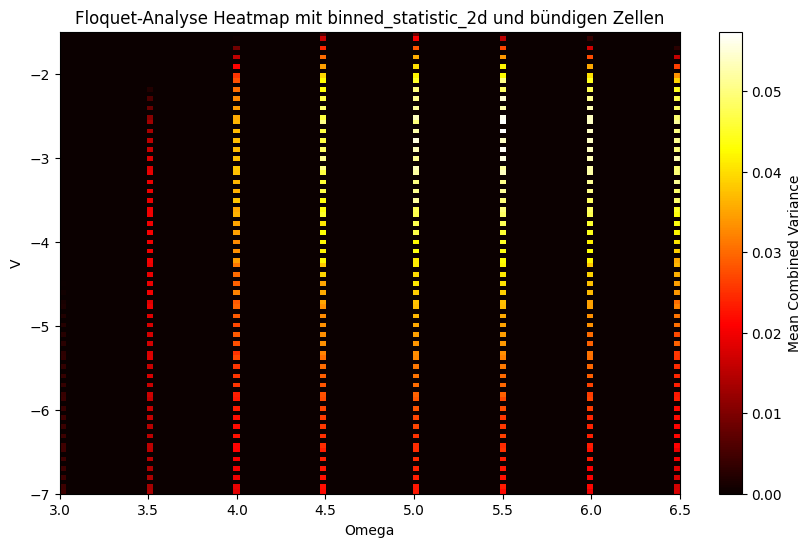

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d

# Daten laden
df_full = pd.read_pickle(r"/home/paul/Documents/atm/Bachelor-Arbeit-master/ground_state_final_test_12_08.pkl")

# Extrahiere relevante Parameter und Varianzen
Omega = np.array([params[3] for params in df_full['additional params']])
V_vals = np.array([params[7] for params in df_full['additional params']])

psi_00_var = df_full['var_<0|0>'].to_numpy()
psi_11_var = df_full['var_<1|1>'].to_numpy()
psi_22_var = df_full['var_<2|2>'].to_numpy()

# Setze die neue Varianzschwelle auf 10^-7
variance_threshold = 1e-7
filtered_indices = np.where((psi_00_var > variance_threshold) | 
                            (psi_11_var > variance_threshold) | 
                            (psi_22_var > variance_threshold))[0]

# Gefilterte Daten
Omega_filtered = Omega[filtered_indices]
V_vals_filtered = V_vals[filtered_indices]

# Kombiniere die Varianzen (hier den Betrag verwenden, falls sie komplex sind)
combined_var = np.abs(psi_00_var[filtered_indices]) + np.abs(psi_11_var[filtered_indices]) + np.abs(psi_22_var[filtered_indices])

# Erstellen eines regelmäßigen Gitters
x_bins = 100  # Anzahl der Bins für Omega
y_bins = 100  # Anzahl der Bins für V

# Erstellen der binned_statistic_2d für die Heatmap
stat, x_edges, y_edges, binnumber = binned_statistic_2d(
    Omega_filtered, V_vals_filtered, combined_var, statistic='mean', bins=[x_bins, y_bins])

# Plot der Heatmap
plt.figure(figsize=(10, 6))

# Verwende shading='auto' für bündige Zellen und np.nan_to_num, um NaN durch 0 zu ersetzen
plt.pcolormesh(x_edges, y_edges, np.nan_to_num(stat.T), cmap='hot', shading='auto')
plt.colorbar(label='Mean Combined Variance')

plt.xlabel('Omega')
plt.ylabel('V')
plt.title('Floquet-Analyse Heatmap mit binned_statistic_2d und bündigen Zellen')
plt.show()


Floquette analyse durchführen

In [2]:
filtered_indices 

array([   211,    212,    213, ..., 126358, 126359, 126360])

In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic_2d
from scipy.integrate import solve_ivp
from concurrent.futures import ThreadPoolExecutor
import os

# Daten laden
df_full = pd.read_pickle(r"/home/paul/Documents/atm/Bachelor-Arbeit-master/ground_state_final_test_12_08.pkl")

# Extrahiere relevante Parameter und Varianzen
Omega = np.array([params[3] for params in df_full['additional params']])
V_vals = np.array([params[7] for params in df_full['additional params']])

psi_00_var = df_full['var_<0|0>'].to_numpy()
psi_11_var = df_full['var_<1|1>'].to_numpy()
psi_22_var = df_full['var_<2|2>'].to_numpy()

# Setze die neue Varianzschwelle auf 10^-6
variance_threshold = 1e-6
filtered_indices = np.where((psi_00_var > variance_threshold) | 
                            (psi_11_var > variance_threshold) | 
                            (psi_22_var > variance_threshold))[0]

# Gefilterte Daten
Omega_filtered = Omega[filtered_indices]
V_vals_filtered = V_vals[filtered_indices]

# Anzahl der problematischen Floquet-Multiplikatoren
problematic_multipliers_count = []

# Differentialgleichungssystem mit Parametern
def dydt(t, y, params):
    Omega_value, V_value = params
    # Hier verwendest du Omega_value und V_value in den Berechnungen
    # Beispielhafte Systemparameter und Berechnungen
    a, a_dagger, ket00, ket01, ket10, ket11, ket22, ket21, ket12, ket20, ket02 = y
    
    da_dt = -kappa/2 * a - 1j * (gamma * ket01) + eta
    da_dagger_dt = np.conj(da_dt)
    dket00_dt = +Gamma * ket11 + 1j * gamma * (ket10 * a - ket01 * a_dagger)
    dket01_dt = -Gamma/2 * ket01 + 1j * (-delta_1 * ket01 + gamma * (ket11 * a - ket00 * a) - Omega_value/2 * ket02)
    dket10_dt = np.conj(dket01_dt)
    dket11_dt = -Gamma * ket11 + 1j * gamma * (ket01 * a_dagger - ket10 * a) + 1j * Omega_value/2 * (ket21 - ket12)
    dket22_dt = 1j * Omega_value / 2 * (ket12 - ket21)
    dket21_dt = -Gamma/2 * ket21 + 1j * (delta_2 * ket21 - delta_1 * ket21 - gamma * ket20 * a + Omega_value/2 * (ket11 - ket22) + 2 * V_value * ket21 * ket22)
    dket12_dt = np.conj(dket21_dt)
    dket02_dt = 1j * (-delta_2 * ket02 - Omega_value/2 * ket01 - 2 * V_value * ket02 * ket22 + gamma * ket12 * a)
    dket20_dt = np.conj(dket02_dt)
    
    return [da_dt, da_dagger_dt, dket00_dt, dket01_dt, dket10_dt, dket11_dt, dket22_dt, dket21_dt, dket12_dt, dket20_dt, dket02_dt]

# Funktion zur Berechnung der Floquet-Multiplikatoren für ein bestimmtes Omega und V
def perform_floquet_analysis_for_params(Omega_value, V_value):
    # Definiere die Systemparameter und initiale Bedingungen basierend auf Omega und V
    
    # Beispielhafte Anfangswerte, bitte anpassen
    a0 = 0 + 0j
    a_dagger_0 = 0 + 0j
    psi00 = 1
    psi22 = 0 + 0j
    psi20 = 0 + 0j
    psi02 = 0 + 0j
    psi11 = 0 + 0j
    psi10 = 0.0 + 0j
    psi01 = 0.0 + 0j
    psi21 = 0.0 + 0j
    psi12 = 0.0 + 0j

    startcond = [a0, a_dagger_0, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02]

    # Numerische Integration
    t_span = (0, 5000)
    t_eval = np.linspace(0, 5000, 500000)
    
    # Übergabe von params (Omega und V) an dydt
    sol = solve_ivp(dydt, t_span, startcond, method='DOP853', t_eval=t_eval, dense_output=True, args=([Omega_value, V_value],))

    # Perioden extrahieren (zum Beispiel)
    maxima_indices = find_smoothed_maxima(np.real(sol.y[0]), t_eval)
    if len(maxima_indices) > 1:
        period = np.mean(np.diff(t_eval[maxima_indices]))
        periods = [period]
        
        # Berechne die Floquet-Multiplikatoren
        floquet_multipliers = floquet_analysis(sol, periods, num_periods=5)
        
        # Zähle problematische Multiplikatoren
        count = np.sum(np.abs(floquet_multipliers) > (1 + 10**-5))
        return count
    
    return np.nan  # Wenn keine Periode gefunden wird

# Funktion für das Multithreading
def floquet_analysis_thread(Omega_value, V_value):
    return perform_floquet_analysis_for_params(Omega_value, V_value)

# Verwende ThreadPoolExecutor für Multithreading
with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:  # max_workers kann angepasst werden, um die Anzahl der Threads zu steuern
    results = list(executor.map(floquet_analysis_thread, Omega_filtered, V_vals_filtered))

# Konvertiere zu einem numpy array
problematic_multipliers_count = np.array(results)

# Erstellen eines regelmäßigen Gitters
x_bins = 100  # Anzahl der Bins für Omega
y_bins = 100  # Anzahl der Bins für V

# Erstellen der binned_statistic_2d für die Heatmap
stat, x_edges, y_edges, binnumber = binned_statistic_2d(
    Omega_filtered, V_vals_filtered, problematic_multipliers_count, statistic='mean', bins=[x_bins, y_bins])

# Plot der Heatmap
plt.figure(figsize=(10, 6))

# Verwende shading='auto' für bündige Zellen und np.nan_to_num, um NaN durch 0 zu ersetzen
plt.pcolormesh(x_edges, y_edges, np.nan_to_num(stat.T), cmap='hot', shading='auto')
plt.colorbar(label='Anzahl problematischer Floquet-Multiplikatoren')

plt.xlabel('Omega')
plt.ylabel('V')
plt.title('Heatmap der problematischen Floquet-Multiplikatoren')

# Speichern des Plots
save_path = '/home/paul/Documents/atm/plots/floquet_heatmap.pdf'
plt.savefig(save_path, format='pdf')  # Speichern des Plots

# Plot anzeigen
plt.show()

print(f"Plot wurde erfolgreich unter {save_path} gespeichert.")


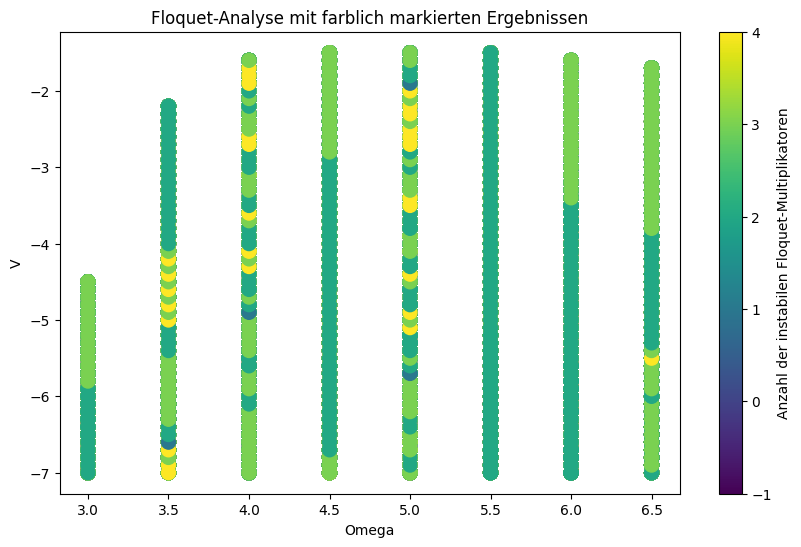

In [53]:
# Konvertiere die Heatmap-Daten in ein numpy-Array
heatmap_data = np.array(heatmap_data)





# Erstellen des Plots
plt.figure(figsize=(10, 6))

# Plot für die analysierten Punkte (farbige Punkte)
scatter = plt.scatter(heatmap_data[:, 0], heatmap_data[:, 1], c=heatmap_data[:, 2],
                      cmap='viridis', vmin=-1, vmax=4, s=100)

# Achsenbeschriftungen und Titel
plt.xlabel('Omega')
plt.ylabel('V')
plt.title('Floquet-Analyse mit farblich markierten Ergebnissen')

# Farbskala für die Anzahl der instabilen Floquet-Multiplikatoren
plt.colorbar(scatter, label='Anzahl der instabilen Floquet-Multiplikatoren')

# Zeige den Plot

plt.savefig('/home/paul/Documents/atm/plots/floquet_heatmap.pdf')
plt.show()


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Beispielhafte Omega- und V-Werte für die Demonstration (diese sollten in der Realität aus deinen Daten kommen)
example_omega = unique_Omega[0]
example_v = filtered_V_vals[0]
example_idx = 0  # Beispielhafter Index

# Beispielhafte Parameter für die Rechnung (du musst dies an deine Daten anpassen)
example_params = df_full.iloc[example_idx]['additional params']
kappa, gamma, Gamma, Omega, delta_1, delta_2, eta, V = example_params

# Anfangsbedingungen (kann ebenfalls angepasst werden)
a0 = 0
a_dagger_0 = 0
psi00 = 1
psi22 = 0
psi02 = 0
psi20 = 0
psi11 = 0 + 0j
psi10 = 0.0 + 0j
psi01 = 0.0 + 0j
psi21 = 0.0 + 0j
psi12 = 0.0 + 0j

startcond = [a0, a_dagger_0, psi00, psi01, psi10, psi11, psi22, psi21, psi12, psi20, psi02]

# Differentialgleichungssystem
def dydt(t, y):
    a, a_dagger, ket00, ket01, ket10, ket11, ket22, ket21, ket12, ket20, ket02 = y
    
    da_dt = -kappa/2 * a - 1j * (gamma * ket01) + eta
    da_dagger_dt = np.conj(da_dt)
    dket00_dt = +Gamma * ket11 + 1j * gamma * (ket10 * a - ket01 * a_dagger)
    dket01_dt = -Gamma/2 * ket01 + 1j * (-delta_1 * ket01 + gamma * (ket11 * a - ket00 * a) - Omega/2 * ket02)
    dket10_dt = np.conj(dket01_dt)
    dket11_dt = -Gamma * ket11 + 1j * gamma * (ket01 * a_dagger - ket10 * a) + 1j * Omega/2 * (ket21 - ket12)
    dket22_dt = 1j * Omega / 2 * (ket12 - ket21)
    dket21_dt = -Gamma/2 * ket21 + 1j * (delta_2 * ket21 - delta_1 * ket21 - gamma * ket20 * a + Omega/2 * (ket11 - ket22) + 2 * V * ket21 * ket22)
    dket12_dt = np.conj(dket21_dt)
    dket02_dt = 1j * (-delta_2 * ket02 - Omega/2 * ket01 - 2 * V * ket02 * ket22 + gamma * ket12 * a)
    dket20_dt = np.conj(dket02_dt)
    
    return [da_dt, da_dagger_dt, dket00_dt, dket01_dt, dket10_dt, dket11_dt, dket22_dt, dket21_dt, dket12_dt, dket20_dt, dket02_dt]

# Numerische Integration
t_span = (0, 2000)
t_eval = np.linspace(0, 2000, 20000)
sol = solve_ivp(dydt, t_span, startcond, method='DOP853', t_eval=t_eval, dense_output=True, atol=1e-8, rtol=1e-10)

# Floquet-Analyse (ein Beispiel für die Berechnung der Multiplikatoren)
def numerical_jacobian(y, dydt, epsilon=1e-8):
    n = len(y)
    J_num = np.zeros((n, n), dtype=complex)
    for i in range(n):
        y_eps_plus = np.copy(y)
        y_eps_minus = np.copy(y)
        y_eps_plus[i] += epsilon
        y_eps_minus[i] -= epsilon
        f_eps_plus = np.array(dydt(0, y_eps_plus))
        f_eps_minus = np.array(dydt(0, y_eps_minus))
        J_num[:, i] = (f_eps_plus - f_eps_minus) / (2 * epsilon)
    return J_num

def floquet_analysis_inner(sol, periods, num_periods=5):
    t_fin = sol.t[-1]
    t_start = t_fin - periods[-1] * num_periods
    y0 = sol.sol(t_start)
    n = len(y0)
    J0 = np.eye(n, dtype=complex)

    def variational_eq(t, Y):
        Y = Y.reshape((n, n + 1))
        dy = dydt(t, Y[:, 0])
        A = numerical_jacobian(Y[:, 0], dydt)
        
        dYdt = np.zeros_like(Y)
        dYdt[:, 0] = dy
        dYdt[:, 1:] = A @ Y[:, 1:]
        return dYdt.flatten()

    t_eval = np.linspace(t_start, t_fin, num_periods * 100)
    Y0 = np.hstack([y0[:, None], J0]).flatten()
    sol_var = solve_ivp(variational_eq, [t_start, t_fin], Y0, t_eval=t_eval, method='DOP853', dense_output=True)

    YT = sol_var.sol(t_fin).reshape((n, n + 1))
    monodromy_matrix = YT[:, 1:]
    floquet_multipliers = np.linalg.eigvals(monodromy_matrix)
    floquet_multipliers_single_period = np.power(floquet_multipliers, 1/num_periods)

    return floquet_multipliers_single_period

# Maxima für jede Lösung finden
def find_maxima(y, t, ignore_time=500):
    maxima_indices = []
    ignore_index = np.searchsorted(t, ignore_time)
    for i in range(ignore_index, len(y) - 1):
        if y[i - 1] < y[i] and y[i + 1] < y[i]:
            maxima_indices.append(i)
    return maxima_indices

# Berechne die Perioden und Floquet-Multiplikatoren
y = sol.y
periods = []
for i in range(len(y)):
    maxima_indices = find_maxima(np.real(y[i]), sol.t)
    if len(maxima_indices) > 1:
        period = np.mean(np.diff(sol.t[maxima_indices]))
        periods.append(period)
    else:
        periods.append(np.nan)

if not np.isnan(periods).all():
    floquet_multipliers = floquet_analysis_inner(sol, periods, num_periods=5)
    
    # Ausgabe der Floquet-Multiplikatoren
    print(f"Floquet-Multiplikatoren für Omega = {example_omega} und V = {example_v}:")
    print(floquet_multipliers)
else:
    print("Keine Perioden gefunden. Floquet-Analyse konnte nicht durchgeführt werden.")


Floquet-Multiplikatoren für Omega = 3.0 und V = -7.0:
[1.48797274+8.30883716e-01j 1.2721873 +5.68934859e-01j
 0.94138268+1.58651520e-01j 0.59949817-4.08854855e-01j
 0.72891941-1.09341166e-01j 0.65586575+8.32771637e-02j
 0.61001999-8.32022215e-02j 0.47144915+3.20096920e-01j
 0.53333454+3.26830206e-02j 1.        -3.93021009e-10j
 1.        +3.93020663e-10j]
